# DynaQ and DynaQ+

#### Testear os algoritimos de planning DynaQ e DynaQ+ em um ambiente que muda em algum momento da interalçao e comparar a adaptação desses algoritimos com o algoritimo de Q-Learning

O ambiente é um GridWorld de 12 por 12 com uma parede que possui uma abertura de dois blocos na extremidade esquerda, no meio do treinamento um bloco na extremidade direita será removido criando um "atalho" para o agente

In [1]:
import numpy as np
import matplotlib.pyplot as plt
a = np.arange(12*12).reshape((12, 12))
a

array([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11],
       [ 12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23],
       [ 24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35],
       [ 36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47],
       [ 48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59],
       [ 60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71],
       [ 72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83],
       [ 84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95],
       [ 96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107],
       [108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119],
       [120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131],
       [132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143]])

In [26]:
#Criação da classe do envirorment
class MyEnv:
    def __init__(self, num_lines=12, num_cols=12):
        self.num_cols = num_cols
        self.num_lines = num_lines
        self.init_state = 140
        self.terminal_state = 11
        self.wall = [73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83]
        self.step_reward = -1
        self.terminal_reward = 1
        self.terminal = False
        self.state = None
        self.last_state = None
        self.num_states = self.num_cols * self.num_lines
        self.num_actions = 4
    #-------------------------------------------------------- 
    def init(self):
        self.state = self.init_state
        self.terminal = False
        return self.state, self.terminal
    #-------------------------------------------------------- 
    def step(self, action):
        self.last_state = self.state
        #Se ainda não tiver atingido o estado terminal
        if (self.terminal == False):
            #action = 0 -> CIMA
            if (action == 0): 
                #Se o estado atual não estiver na borda superior pode ir para cima
                if (self.state >= self.num_cols):
                    self.state = self.state - self.num_cols
                reward = self.step_reward

            #action = 1 -> DIREITA
            elif (action == 1):
                #Se o estado atual não estiver na borda da direita pode ir para a direita
                if((self.state + 1) % self.num_cols != 0):
                    self.state = self.state + 1
                reward = self.step_reward

            #action = 2 -> BAIXO
            elif (action == 2):
                if(self.state < (self.num_lines - 1) * self.num_cols):
                    self.state = self.state + self.num_cols
                reward = self.step_reward

            #action = 3 -> ESQUERDA
            elif (action == 3):
                if(self.state % self.num_cols != 0):
                    self.state = self.state - 1
                reward = self.step_reward

            #Se o estado atual estiver na parede volta p/ o estado anterior
            if self.state in self.wall:
                self.state = self.last_state
                reward = self.step_reward

            #Ainda não atingiu o estado terminal
            self.terminal = False

            #Se o estado for o terminal o reward é 0 e terminal = True
            if(self.state == self.terminal_state):
                reward = self.terminal_reward
                self.terminal = True
        
        #Se ja tiver atingido o estado terminal
        else:
            self.terminal = True
            reward = 0
            
        return self.state, reward, self.terminal 
    #-------------------------------------------------------- 
    def change(self):
        #Modifica o ambiente e cria um atalho, removendo o ultimo bloco da parede
        self.wall = [73,  74,  75,  76,  77,  78,  79,  80,  81, 82]
    #-------------------------------------------------------- 
    def getStates(self):
        return self.num_states
    #-------------------------------------------------------- 
    def getActions(self):
        return self.num_actions

In [33]:
class MyAgent:
    def __init__(self, ag_type, step_size = 0.5, discount = 1.0, epsilon = 0.1, kappa = 0.07, num_planning = 30):
        self.ag_type = ag_type #q, dynaq, dynaq+
        self.step_size = step_size
        self.discount = discount
        self.epsilon = epsilon
        self.q_values = None
        if(self.ag_type == "dynaq" or self.ag_type == "dynaq+"):
            self.kappa = kappa
            self.model = {}
            self.num_planning = num_planning
            if(self.ag_type == "dynaq+"):
                self.tau = None
    #-------------------------------------------------------- 
    def train(self, env, num_episodes, change):
        
        #Pega o numero de estados e onumero de ações do ambiente
        num_states = env.getStates()
        num_actions = env.getActions()
        
        if(self.ag_type == "dynaq" or self.ag_type == "dynaq+"):
            self.tau = np.zeros((num_states, num_actions))
        
        #Inicializa os action-values como zero
        self.q_values = np.zeros((num_states, num_actions))
        
        #Vetores que irão armazenar a soma das rewards em cada episodio e o numero de steps por episodio
        rewards = np.zeros(num_episodes)
        steps = np.zeros(num_episodes)
        
        #Vetor com o numero de visitas em cada estado nos ultimos 10 episodios
        visits = np.zeros(num_states)
        
        #Reliza todos os episodes
        for episode in range(num_episodes):
            
            #Te tiver atingido 2/3 to treinamento o ambiente muda
            if(episode == int((3/4)*num_episodes) and change == True):
                env.change()
            
            #Armazena o estado inicial e a ação inicial
            prev_state, terminal = env.init()
            
            if(num_episodes - episode <=10):
                visits[prev_state] += 1
            
            #Escolhe a ação de acordo com o metodo epsilon-soft
            if(np.random.rand() < self.epsilon):
                prev_action = np.random.randint(num_actions)
            else:
                prev_action = self.argmax(self.q_values[prev_state, :], num_actions)
            
            #Enquanto não atingir o estado terminal
            while(terminal is False):
                
                #Realiza a acao no ambiente baseado no ultimo estado
                state, reward, terminal = env.step(prev_action)
                
                #Ecolhe uma nova acao baseando no estado atual
                if(np.random.rand() < self.epsilon):
                    action = np.random.randint(num_actions)
                else:
                    action = self.argmax(self.q_values[state, :], num_actions)
                
                #Atualiza os action values durante a interação com o ambiente
                self.q_values[prev_state, prev_action] = self.q_values[prev_state, prev_action] + self.step_size*(reward + self.discount*np.amax(self.q_values[state, :]) - self.q_values[prev_state, prev_action])
                
                #As etapas de model update e planning são relizadas apenas no DynaQ e DynaQ+
                if(self.ag_type == "dynaq" or self.ag_type == "dynaq+"):
                    
                    #Soma no os valores de tau das transições que não foram exploradas em 1 e zera o valor de tau da ultima transição visitada
                    if(self.ag_type == "dynaq+"):
                        self.tau += 1
                        self.tau[prev_state, prev_action] = 0
                    
                    #MODEL UPDATE
                    if(prev_state in self.model):
                        self.model[prev_state].update({prev_action: (state, reward)})
                    else:
                        self.model[prev_state] = {prev_action: (state, reward)}
                        
                        #No DynaQ+ todas as ações em um estado (transições) devem ser adicionadas ao modelo
                        if(self.ag_type == "dynaq+"):
                            for act in range(num_actions):
                                if(act != prev_action):
                                    self.model[prev_state][act] = (prev_state, 0)
                        
                    #PLANNING
                    for _ in range(self.num_planning):
                        #Escolhe aleatoriamente um estado visitado anteriormente e uma ação possivel nesse estado
                        pl_state = np.random.choice([st for st in self.model])
                        pl_action = np.random.choice([act for act in self.model[pl_state]])
                        
                        #Observa o proximo estado (s_) e a reward (r) resultantes dessa transição
                        s_, r = self.model[pl_state][pl_action]
                        
                        #No DynaQ+ a reward deve ser somada ao kappa*sqrt(tau)
                        if(self.ag_type == "dynaq+"):
                            r += self.kappa*np.sqrt(self.tau[pl_state, pl_action])
                        
                        #O valor do action value é atualizado durante o planning
                        self.q_values[pl_state, pl_action] += self.step_size*(r + self.discount*np.amax(self.q_values[s_, :] - self.q_values[pl_state, pl_action]))
        
                #Os estado e ação atuais passam a ser os anteriores
                prev_state = state
                prev_action = action
                
                #Adiciona o reward ao reward total do episodio
                rewards[episode] += reward
                steps[episode] += 1
                
                #Se estiver nos ultimos 10 episodios começa a armazenar as visitas em cada episodio
                if(num_episodes - episode <=10):
                    visits[state] += 1 
        
        #Retorna os rewards de cada episodio, os action-values finais e o numero de visitas em cada episodio  
        return rewards, steps, visits
    
    #-------------------------------------------------------- 
    def argmax(self, q_values, act_num):
        '''Funcao que retorna o indice do valor maximo de um vetor q_values, 
        caso haja mais de um valor maximo entao retorna um deles aletoriamente'''
        top_value = float("-inf") #maior Q(a)
        ties = [] #Acoes que empataram entre o maior valor de Q(a)
        for i in range(act_num):
            if(q_values[i] > top_value):     #Se o Q(a) for maior que o maximo ate o momento:
                top_value = q_values[i]          #Substitui o Q(a) maximo pelo valor do atual
                ties = []                        #Zera o vetor de empates das acoes com o Q(a) maximo
                ties.append(i)                   #Adiciona a acao atual no vetor de empates
            elif(q_values[i] == top_value):  #Se o Q(a) for igual ao maximo ate o momento:
                ties.append(i)                   #Adiciona a ação ao vetor de empates
        return np.random.choice(ties)            #Retorna um valor aleatorio do vetor de empates do Q maximo

In [34]:
num_lines = 12
num_cols = 12
env = MyEnv(num_lines, num_cols)

In [35]:
num_ep = 1000
t = np.arange(num_ep)

q_agt = MyAgent(ag_type = "q", step_size = 0.3, discount = 1, epsilon = 0.05)
q_r, q_s, q_v = q_agt.train(env, num_ep, change = True)
print("Q-learning finished")

dq_agt = MyAgent(ag_type = "dynaq", step_size = 0.3, discount = 1, epsilon = 0.05, num_planning = 10)
dq_r, dq_s, dq_v = dq_agt.train(env, num_ep, change = True)
print("DynaQ finished")

dqp_agt = MyAgent(ag_type = "dynaq+", step_size = 0.3, discount = 1, epsilon = 0.05, kappa = 0.002, num_planning = 10)
dqp_r, dqp_s, dqp_v = dqp_agt.train(env, num_ep, change = True)
print("DynaQ+ finished")

Q-learning finished
DynaQ finished
DynaQ+ finished


### Grafico do reward de cada metodo no final de cada episode

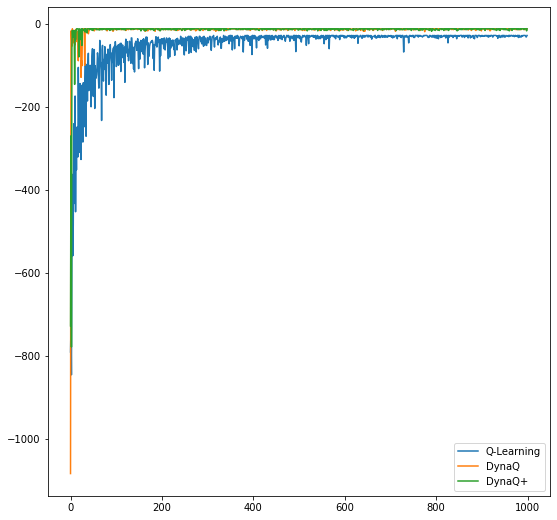

In [36]:
plt.figure(figsize=(9, 9))
plt.plot(t, q_r, label='Q-Learning')
plt.plot(t, dq_r, label="DynaQ")
plt.plot(t, dqp_r, label="DynaQ+")
plt.legend()

### Grafico do numero de steps de cada metodo para completar cada episode

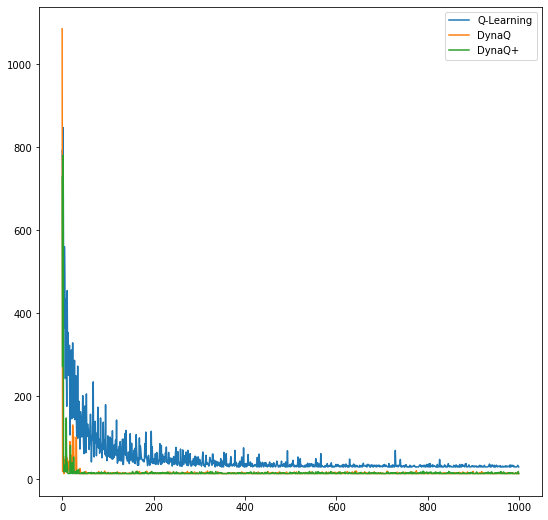

In [37]:
plt.figure(figsize=(9, 9))
plt.plot(t, q_s, label='Q-Learning')
plt.plot(t, dq_s, label="DynaQ")
plt.plot(t, dqp_s, label="DynaQ+")
plt.legend()

### Frequencia de visitas de cada metodo nos estados nos ultimos 10 episodes

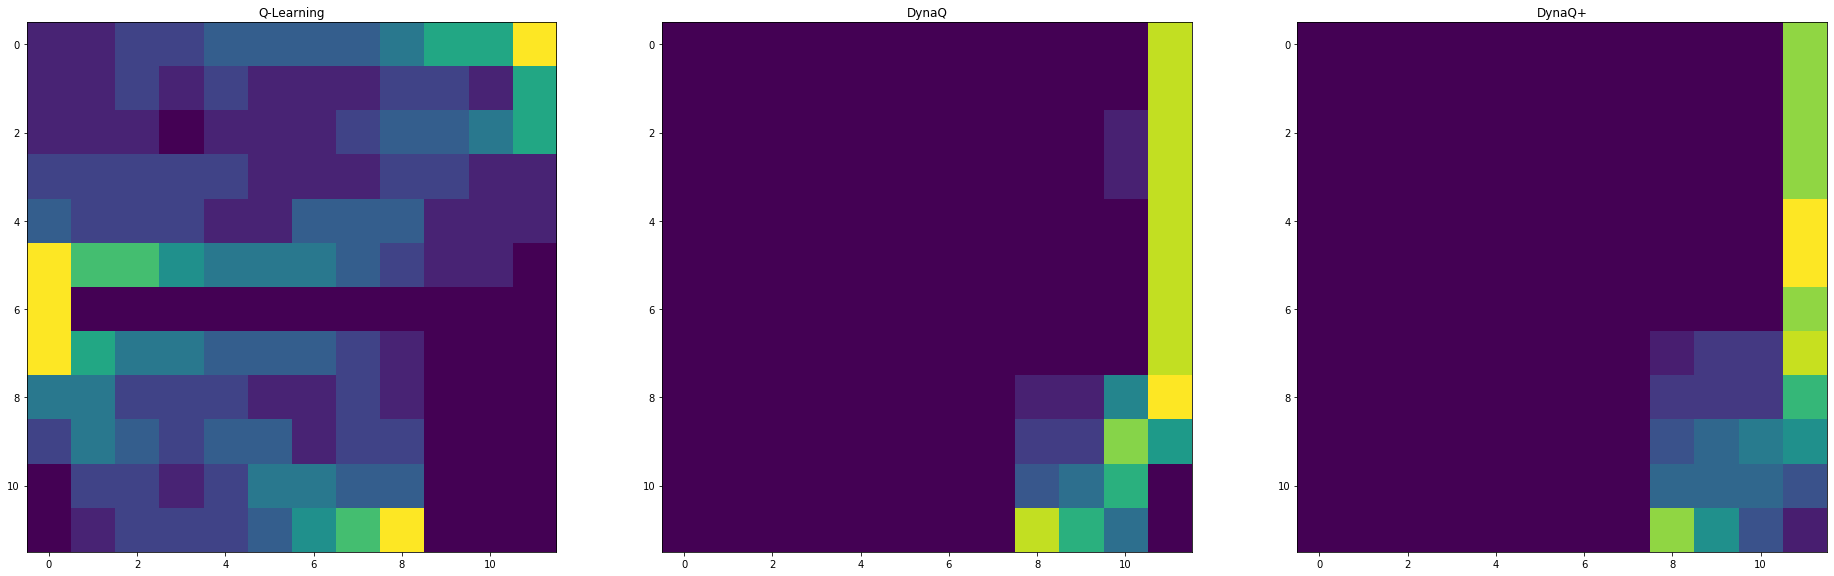

In [38]:
plt.figure(figsize=(5, 5)) 
plt.subplot(131)
plt.imshow(q_v.reshape(num_lines, num_cols))
plt.title("Q-Learning")
plt.subplot(132)
plt.imshow(dq_v.reshape(num_lines, num_cols))
plt.title("DynaQ")
plt.subplot(133)
plt.imshow(dqp_v.reshape(num_lines, num_cols))
plt.title("DynaQ+")
plt.subplots_adjust(left=0, bottom=0, right=5, top=10, wspace=0.2, hspace=0.2)
plt.show()